<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/GAN_2_Simple_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87


In [1]:
import os
import numpy as np

from IPython.core.debugger import Tracer

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.switch_backend('agg') # allows code to run without a system DISPLAY


In [2]:
class GAN(object):
    """ Generative Adversarial Network class """
    def __init__(self, width=28, height=28, channels=1):

        self.width = width
        self.height = height
        self.channels = channels

        self.shape = (self.width, self.height, self.channels)

        self.optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

        self.G = self.__generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.D = self.__discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()

        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)


    def __generator(self):
        """ Declare generator """

        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
        model.add(Reshape((self.width, self.height, self.channels)))

        return model

    def __discriminator(self):
        """ Declare discriminator """

        model = Sequential()
        model.add(Flatten(input_shape=self.shape))
        model.add(Dense((self.width * self.height * self.channels), input_shape=self.shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.width * self.height * self.channels)/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model

    def __stacked_generator_discriminator(self):

        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model

    def train(self, X_train, epochs=20000, batch = 32, save_interval = 100):

        DD_loss = np.zeros((epochs,))
        GG_loss = np.zeros((epochs,))
        for cnt in range(epochs):

            ## train discriminator
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            legit_images = X_train[random_index : random_index + np.int64(batch/2)].reshape(np.int64(batch/2), self.width, self.height, self.channels)

            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            syntetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator

            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

            DD_loss[cnt] = d_loss[0]
            GG_loss[cnt] = g_loss
            if cnt % save_interval == 0:
                self.plot_images(save2file=True, step=cnt)
        return  DD_loss, GG_loss

    def plot_images(self, save2file=False, samples=16, step=0):
        ''' Plot and generated images '''
        if not os.path.exists("./images"):
            os.makedirs("./images")
        filename = "./images/mnist_%d.png" % step
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)

        plt.figure(figsize=(10, 10))

        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.height, self.width])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()





In [3]:

(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

gan = GAN()
DD, GG = gan.train(X_train, epochs=200)

11493376/11490434 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 392)               307720    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 392)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 393       
Total params: 923,553
Trainable params: 923,553
Non-tra

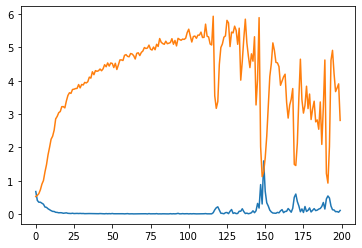

In [4]:
% matplotlib inline 
plt.figure
plt.plot(DD)
plt.plot(GG)

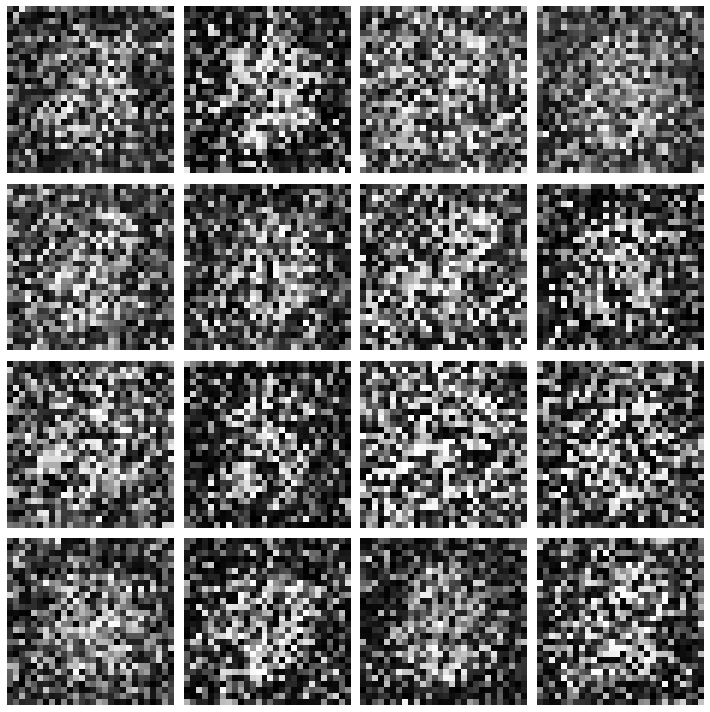

In [5]:
% matplotlib inline 
gan.plot_images()

In [6]:

DD_2000, GG_2000 = gan.train(X_train, epochs=2000)

epoch: 0, [Discriminator :: d_loss: 0.120934], [ Generator :: loss: 3.117144]
epoch: 1, [Discriminator :: d_loss: 0.129633], [ Generator :: loss: 3.562830]
epoch: 2, [Discriminator :: d_loss: 0.087063], [ Generator :: loss: 2.957852]
epoch: 3, [Discriminator :: d_loss: 0.125290], [ Generator :: loss: 3.514248]
epoch: 4, [Discriminator :: d_loss: 0.182102], [ Generator :: loss: 2.166253]
epoch: 5, [Discriminator :: d_loss: 0.198824], [ Generator :: loss: 3.094325]
epoch: 6, [Discriminator :: d_loss: 0.281323], [ Generator :: loss: 2.160695]
epoch: 7, [Discriminator :: d_loss: 0.221673], [ Generator :: loss: 3.767156]
epoch: 8, [Discriminator :: d_loss: 0.196884], [ Generator :: loss: 1.991242]
epoch: 9, [Discriminator :: d_loss: 0.282414], [ Generator :: loss: 4.506358]
epoch: 10, [Discriminator :: d_loss: 0.262292], [ Generator :: loss: 1.251069]
epoch: 11, [Discriminator :: d_loss: 0.442514], [ Generator :: loss: 2.073017]
epoch: 12, [Discriminator :: d_loss: 0.212928], [ Generator ::

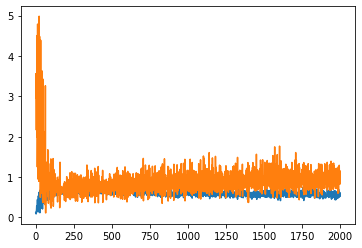

In [7]:
% matplotlib inline 
plt.figure
plt.plot(DD_2000)
plt.plot(GG_2000)

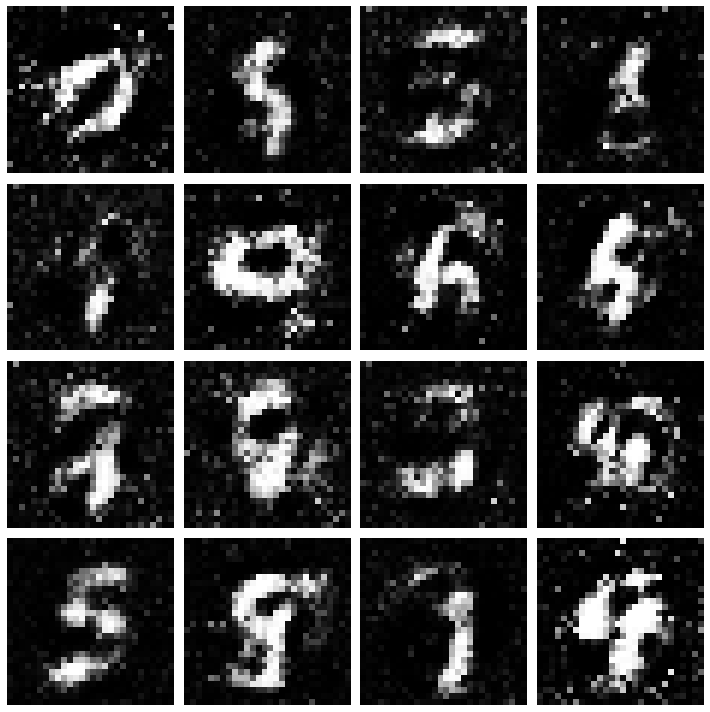

In [8]:
gan.plot_images()

In [9]:

DD_20000, GG_20000 = gan.train(X_train, epochs=20000)

Se han truncado las últimas 5000 líneas del flujo de salida.
epoch: 15000, [Discriminator :: d_loss: 0.609672], [ Generator :: loss: 0.878474]
epoch: 15001, [Discriminator :: d_loss: 0.564604], [ Generator :: loss: 0.955923]
epoch: 15002, [Discriminator :: d_loss: 0.697118], [ Generator :: loss: 0.869954]
epoch: 15003, [Discriminator :: d_loss: 0.620643], [ Generator :: loss: 0.797710]
epoch: 15004, [Discriminator :: d_loss: 0.673414], [ Generator :: loss: 0.728875]
epoch: 15005, [Discriminator :: d_loss: 0.723213], [ Generator :: loss: 0.758398]
epoch: 15006, [Discriminator :: d_loss: 0.698405], [ Generator :: loss: 0.947437]
epoch: 15007, [Discriminator :: d_loss: 0.600592], [ Generator :: loss: 0.828645]
epoch: 15008, [Discriminator :: d_loss: 0.667610], [ Generator :: loss: 0.914174]
epoch: 15009, [Discriminator :: d_loss: 0.590333], [ Generator :: loss: 0.810480]
epoch: 15010, [Discriminator :: d_loss: 0.623559], [ Generator :: loss: 0.876372]
epoch: 15011, [Discriminator :: d_los

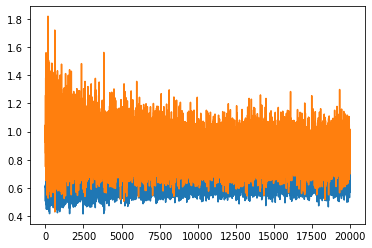

In [10]:
% matplotlib inline 
plt.figure
plt.plot(DD_20000)
plt.plot(GG_20000)

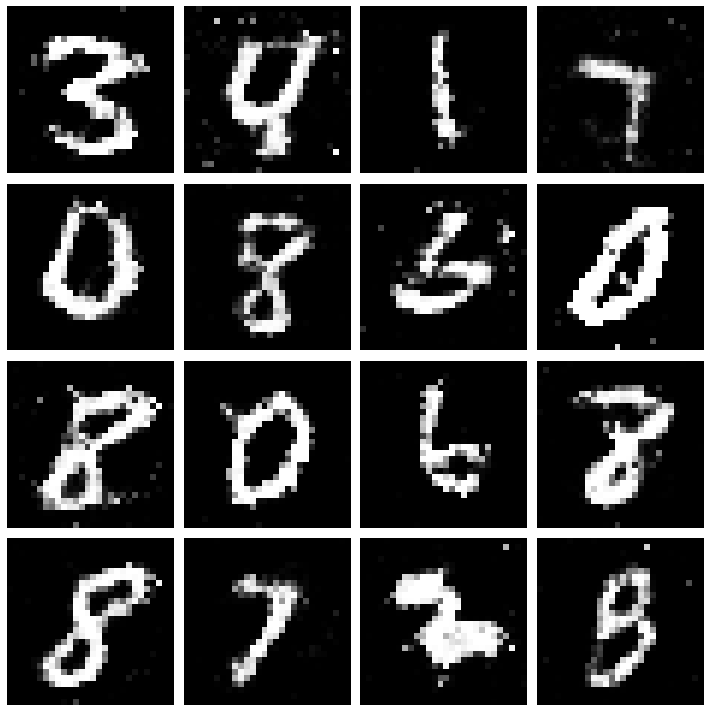

In [11]:
gan.plot_images()